In [1]:
# For training
from keras.applications import VGG16
from keras import models, optimizers, layers
from keras.preprocessing.image import ImageDataGenerator
# Testing plugin
from livelossplot import PlotLossesKeras

/home/sagacius/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
height = 256
width = 256
batch_size = 50
train_dir = 'ImagesForFlow2/train/'
validation_dir = 'ImagesForFlow2/validation/'

In [3]:
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))
vgg_conv.trainable = True
#print(len(vgg_conv.trainable_weights))
set_trainable = False
for layer in vgg_conv.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
#print(len(vgg_conv.trainable_weights))
#vgg_conv.summary()

In [4]:
model = models.Sequential()

model.add(vgg_conv)

#model.add(layers.Flatten())
#model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dense(163, activation='sigmoid'))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1714, activation='softmax'))

#model.summary()

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
validation_datagen = ImageDataGenerator(rescale=1./255)

val_batchsize = int(batch_size / 10)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=val_batchsize,
    class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=0.01),
              metrics=['acc'])

Found 95707 images belonging to 1714 classes.
Found 27343 images belonging to 1714 classes.


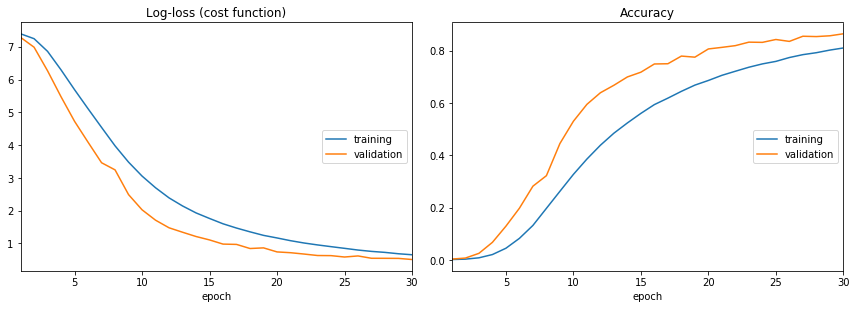

In [6]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    callbacks=[PlotLossesKeras()],
    verbose=1)

In [7]:
model.save('Models/mark2.h5')

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

In [9]:
import numpy as np
nacc = np.asarray(acc)
nval_acc = np.asarray(val_acc)
nloss = np.asarray(loss)
nval_loss = np.asarray(val_loss)
logs_mark = np.row_stack((nacc, nval_acc, nloss, nval_loss))

In [11]:
print(logs_mark.shape)

(4, 30)


In [12]:
np.save("Logs/mark2.npy", logs_mark)